# <center>Medical Imaging</center>
# <center>Practical session 2: Monte Carlo simulation </center>
***
*Jens Maebe, Florence Muller*

18/10/2022

# Practical information
- Work in groups of 2 (same groups as before).
- Report (this notebook) due **2 weeks** after the session.
- Hand in your **notebook** in **.ipynb** and **.html** format (File -> Download as -> HTML) via Ufora. It is normal that some pictures in the text are missing in the .html file, as long as your own plots show up correctly.
- We are here to help you: ask questions!
    - Jens.Maebe@UGent.be
    - FlorenceMarie.Muller@UGent.be

**Deadline for this session: 1 November 2022 at 23:59**.

# Introduction

The purpose of this exercise session is to obtain insight in the different steps involved in the Monte Carlo (MC) simulation of a positron emission tomography (PET) scanner. We will use MC techniques to simulate a PET acquisition, instead of using analytical forward projections.

## Positron emission tomography

A positron emission tomography (PET) scanner measures the distribution of a tracer, labeled with a radioactive isotope, in the body of a patient. Since the tracer is subject to a certain metabolism in the patient, 3D physiological information can be obtained with a PET scanner. The technique is thus complementary to a CT scan, which images only anatomy.

PET makes use of positron emitting radiotracers. When a positron emission occurs, the positron is quickly annihilated with a nearby electron, emitting two 511 keV gamma photons in random but opposite (back-to-back) directions. These gamma photons can be detected by the PET scanner, and when two of these detections happen within a certain coincidence time window, both are assigned to the same annihilation event. A line-of-response (LOR) can then be drawn between the two detection positions, for which is known that the annihilation took place somewhere along that line. By drawing multiple of these LORs, we can obtain a sinogram that can then be reconstructed back into image space by making use of tomographic techniques.

## Monte Carlo simulation

Monte Carlo (MC) simulations are widely used in physics and mathematics when the analytical calculation of a result is too difficult or sometimes even impossible to compute. The method is named after the Monte Carlo Casino, because it relies on repeated **random sampling** or educated guesses to compute a numerical result. 

Simulating a (simplified) PET acquisition can be done in the following 3 main steps:

- Sampling of the source position
- Sampling of the emission angle
- Obtaining the intersections (if any) between the LOR and the scanner
- Generating the sinogram from the detected LORs

In the following exercises, you will implement these steps yourself.

# Exercises

## Exercise 1: Sampling of the source position

The first random number we will use in our PET simulator will be used to pick a random point of photon emission, given a certain (3D) activity map. Here we will randomly select one voxel, taking into account its activity. A higher activity means more photons should originate from that location. 

In order to do so, we should first build the 1D probability density function (PDF) from the activity map. This is done by flattening the activity map into a 1D array, where each index *i* ∈ [0, N-1] represents a voxel (*ix, iy, iz*) in the activity map (N = # voxels). The PDF should be normalized to 1 so that the probability of emission in voxel *i* is equal to its value PDF( *i* ).

Sampling of the PDF is achieved by using the cumulative probability density (CPD), which is obtained by integrating the PDF. In the case of a discrete system, we have:
$$CPD(i) = \sum_{k=1}^{i}{PDF(k)}$$
If the PDF was properly normalized, we should obtain CPD(N)=1.

We can now select a random number *r* between 0 and 1, and relate this number to a voxel by scaling it back to the index using the CPD, see figure 1. We can then convert this linear index *i* back into a 3D index (*ix, iy, iz*). Finally, we convert this voxel index (*ix, iy, iz*) into a spatial coordinate (*x, y, z*) by an optional translation and uniform sampling within the voxel boundaries.

<table>
    <tr>
        <td><img src="images/SourceSampling.png" width="1200"/><figcaption><center>Figure 1: Procedure for sampling a random voxel from an activity map.</center></figcaption></td>
    </tr>
</table>




### <font color='blue'><b>Exercise:</b></font>

- Read in the 64x64x64 activity map "mcatnohdr.npy" (use the function `np.load`) and visualize it by plotting the central slice along each direction.
- Create the PDF and CPD and visualize both. 
- Use a for loop to sample the phantom (making use of the CPD) 100 000 times and store the sampled x, y and z coordinates in a list/1D array. Center the phantom around the origin, so that your sampled coordinates all have values between -32 and 32. Hint: make use of the functions `np.searchsorted` and `np.unravel_index`.
- Every 10 000 th iteration, visualize these sampled coordinates by creating a 3D histogram with `np.histogramdd` and plotting the central slice of this histogram along each direction. Make sure that your histogram always shows the same area, for which you can make use of the optional `bins` and `range` arguments.

### <font color='red'><b>Solution:</b></font>

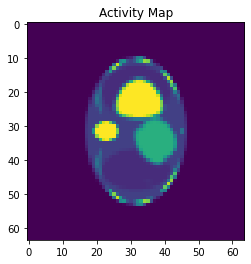

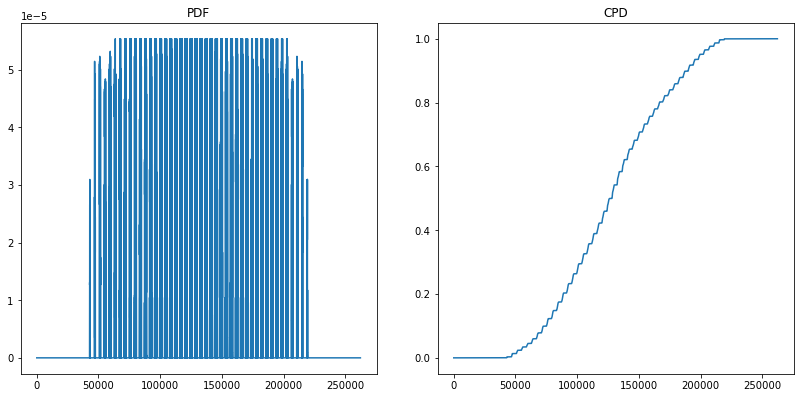

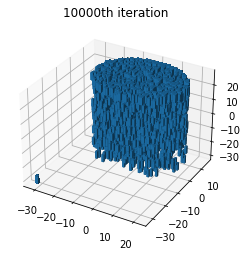

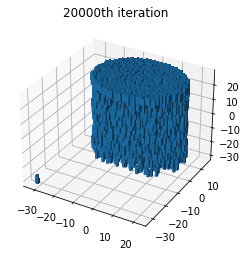

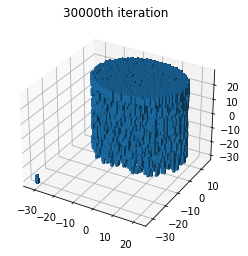

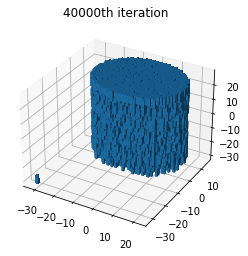

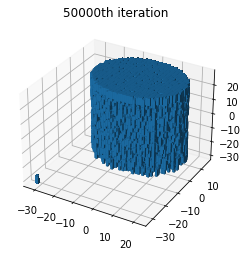

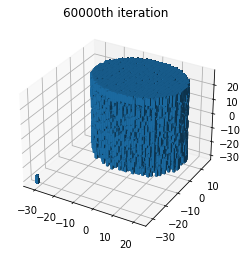

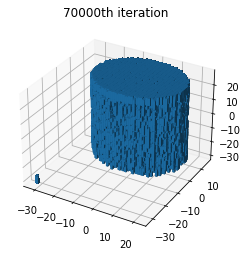

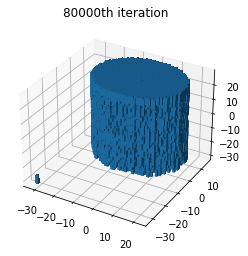

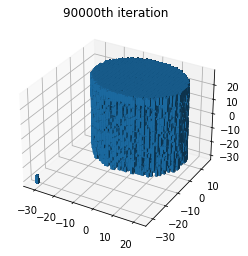

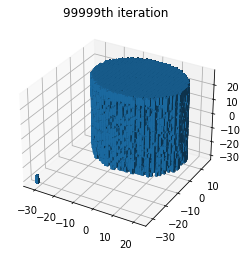

In [149]:
import random
import numpy as np
from matplotlib import pyplot as plt

activity_map = np.load("phantoms/mcatnohdr.npy")
flat_act = activity_map.flatten()

act_pdf = flat_act / (np.sum(flat_act)) # normalizing
act_cpd = np.cumsum(act_pdf) # cumulative sum of the pdf

# ploting 
plt.imshow(activity_map[:, :, 32])
plt.title("Activity Map")
plt.savefig(f"report_2/activity_map.png")
plt.show()

figs, axs = plt.subplots(1, 2, figsize=(12, 6))
figs.tight_layout(pad=3.0)

axs[0].plot(act_pdf)
axs[0].set_title("PDF")

axs[1].plot(act_cpd)
axs[1].set_title("CPD")

plt.savefig(f"report_2/PDF_CPD_plot.png")
plt.show()

length = 100000

x = []
y = []
z = []
for i in range (length):
    r_num = random.choice(act_cpd)
    index = np.searchsorted(act_cpd, r_num)
    unrav = np.unravel_index(index, [64, 64, 64])
    centered_coord = np.array(unrav) - 32

    x.append(centered_coord[0])
    y.append(centered_coord[1])
    z.append(centered_coord[2])
    if ((not (i % 10000) or i == length -1) and i != 0):
        # H, edges = np.histogramdd(centered_coord, bins=64) # from -32 to 32
        
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.bar3d(x, y, z, 1, 1, 5, shade=True)
        ax.set_title(f'{i}th iteration')
        plt.show()
        

## Exercise 2: Sampling of the emission angle

To sample the angle of emission (in 3D) uniformly over the complete solid angle ($4\pi$), we use the spherical coordinate system as defined in figure 2. The emission angle is defined by two components, the azimuthal angle $\phi$ and the polar angle $\theta$. The easiest way to make sure that the 3D angle is sampled uniformly, is to make the PDF of either $\phi$ or $\theta$ uniform (constant), and derive the PDF of the other angle accordingly. Here, we choose the PDF of the azimuthal angle $\phi$ to be uniform, so that the PDF of the polar angle $\theta$ will have to be weighted in order to obtain a uniform sampling over $4\pi$ or, in other words, over the surface of the unit sphere.

<table>
    <tr>
        <td>
            <img src="images/SphericalCoordinates.png" width="600"/>
            <figcaption><center>Figure 2: Polar coordinate system with radial coordinate r, azimuthal angle ϕ and polar angle θ.</center></figcaption>
        </td>
    </tr>
</table>

### Sampling of $\phi$

The PDF for $\phi$ is uniform and given by:

$$ PDF(\phi) = \frac{1}{\phi_{max}} $$

The constant value $1/\phi_{max}$ is chosen so the PDF is normalized to 1, where $\phi_{max}=2\pi$. The CPD is then given by:

$$ CPD(\phi) = \int_{0}^{\phi}{\frac{1}{\phi_{max}}d\phi'} = \frac{\phi}{\phi_{max}} $$

We choose the random number $r_\phi$ (0 ≤ $r_\phi$ < 1) to be equal to the CPD:

$$ r_\phi = CPD(\phi) = \frac{\phi}{\phi_{max}} $$

so that $\phi$ can be derived from the random number $r_\phi$:

$$ \phi = r_\phi\phi_{max} $$

### Sampling of $\theta$

If the PDF of $\theta$ would be uniform, the sampling of the surface of the unit sphere would be denser at the poles while becoming coarser toward the equator. In order to have a uniform sampling over the unit sphere, the PDF of the polar angle $\theta$ has to be chosen proportional to the circumference $C$ of the circle on the unit sphere defined by $\theta$ (see figure 2).

$$ PDF(\theta) \propto C(\theta) $$

Since we want the polar angle to be in between 0 and $\theta_{max}=\pi$, the normalization is given by:

$$ PDF(\theta) = \frac{C(\theta)}{\int_{0}^{\theta_{max}}C(\theta)d\theta} $$

and the CPD is:

$$ CPD(\theta) = \int_{0}^{\theta}PDF(\theta')d\theta'$$

Using above formulas, we can show that the sampling of $\theta$ should be equal to:

$$ \theta = \arccos(1 - r_\theta[1 - \cos(\theta_{max})]) $$

with $r_\theta$ a uniformly chosen random number for which 0 ≤ $r_\theta$ < 1.

### <font color='blue'><b>Exercise:</b></font>

- Proof the equation for the sampling of θ. You can use LateX notation in a markdown cell for this purpose.
- Sample emission angles θ and ϕ uniformely on the unit sphere.
    - Write a function to sample an angle θ.
    - Write a function to sample an angle ϕ.
    - Write a function that transforms the spherical coordinates (r, θ, ϕ) into cartesian coordinates (x, y, z).
    - Sample 100 000 emission angles (θ and ϕ) and transform them into cartesian coordinates on the unit sphere (r=1).
- Check that your sampling is uniform on the unit sphere:
    - Use the function `np.histogramdd` to create a 3D histogram of the sampled cartesian coordinates.
    - Use this histogram to show the sampled emission angles along the X=0, Y=0 and Z=0 planes by making use of the `plt.imshow` function. Do you see what you expected?
    - Now redo the sampling with uniform (incorrect) sampling of θ and again show the X=0, Y=0 and Z=0 slices of the histogram.

### <font color='red'><b> Solution: </b></font>

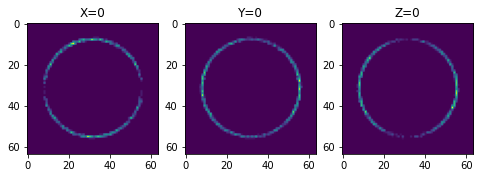

In [141]:
# function to sample an angle theta
def sample_theta():

    r_theta = random.random() # random number from 0 to 1
    theta_max = np.pi

    return np.arccos(1 - (r_theta * (1 - np.cos(theta_max))))

# function to sample an angle phi
def sample_phi():

    r_phi = random.random()
    phi_max = 2 * np.pi

    return r_phi * phi_max


# function that converts spherical coordinates to cartesian coordinates
def spherical_to_cartesian(r, theta, phi, radians=False):

    # if units are not in radians, then convert to degrees 
    if not radians:
        theta = (theta * np.pi) / 180
        phi = (phi * np.pi) / 180    

    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)

    return [x, y, z]


# sampling 100k emission angles
n_angles = 100000

spherical = [[sample_theta(), sample_phi()] for _ in range(n_angles)] # [theta, phi]
cartesian = np.array([spherical_to_cartesian(1, spherical[i][0], spherical[i][1], radians=True) for i in range(n_angles)]) # [x, y, z]

H, edges = np.histogramdd(cartesian, bins=64) # histogram

# plotting 
figs, axs = plt.subplots(1, 3, figsize=(8, 8))

axs[0].imshow(H[0, :, :]) # x=0 plane
axs[0].set_title("X=0")

axs[1].imshow(H[:, 0, :]) # y=0 plane
axs[1].set_title("Y=0")

axs[2].imshow(H[:, :, 0]) # z=0 plane
axs[2].set_title("Z=0")

plt.show()

# Exercise 3: Calculating the intersections

Now that we can sample both an emission position and an emission angle, we can construct the LOR. From this LOR, we can then calculate the intersection points (if any) with the scanner, see figure 3. The LOR can be represented by the parametric line equation:

\begin{equation}
\tag{1}
\text{LOR}(t) = P + Vt
\end{equation}

where P is a point on the LOR (e.g. the emission position) and V is a direction vector which can be derived from the emission angle. We obtain for the LOR:

\begin{equation}
\tag{2}
x = P_{x} + V_{x}t
\end{equation}

\begin{equation}
\tag{3}
y = P_{y} + V_{y}t
\end{equation}

\begin{equation}
\tag{4}
z = P_{z} + V_{z}t
\end{equation}

A PET scanner, with radius r and z-axis oriented along the axial direction, can similarly be represented by the equation for a cylinder, with an additional condition that takes into account the limited axial extent or field-of-view (FOV) of the scanner:

\begin{equation}
\tag{5}
x^2 + y^2 = r^2
\end{equation}

\begin{equation}
\tag{6}
z_{\min} < z < z_{\max}
\end{equation}

<table>
    <tr>
        <td><img src="images/Detections.png" width="1200"/><figcaption><center>Figure 3: PET scanner and LOR intersections.</center></figcaption></td>
    </tr>
</table>

Calculating the intersections of the LOR with the PET scanner can be done in two steps:
- First, we assume the scanner is infinitely long and simply calculate the intersection between the LOR and a cylinder with radius *r*. This can be done by substituting equations 2-4 in equation 5 and solving the new quadratic equation for t. Once we have found the two solutions for t, we can substitute the result back into equations 2-4 to obtain the intersection positions. Note that it is also possible to have only one or zero solutions for t, in which case there is only one or zero intersections.
- Second, we take into account the FOV of the PET scanner (length along the z-axis) by dismissing those solutions where one or both intersections have a z value outside of the PET scanner FOV (equation 6). 

Oftentimes a PET scan is taken at multiple (continuous) bed positions in order to obtain an image with larger FOV than the scanner itself. In this simulation, rather than move the patient (phantom), we will move the scanner. This can be accomplished by choosing a random value for $z_{\min}$ (and updating $z_{\max}$ accordingly) for each event.

### <font color='blue'><b>Exercise:</b></font>

- Simulate a PET acquisition of the "mcatnohdr.npy" phantom with the following settings:
    - The scanner has a radius of 64 pixels and a FOV of 32 pixels. It is centered around the z-axis and during a single acquisition it moves from z=[-32, 0] to z=[0, 32].
    - The phantom is centered around the origin.
    - Simulate 100 000 events, re-using the functions for sampling the source position and the emission angle used in the previous exercises.
- Answer the following questions:
    - What is the sensitivity (# detections / # emissions)?
    - How much does the sensitivity increase if you increase the scanner FOV to 64 pixels and leave it fixed in a single position (z=[-32, 32]) for the whole acquisition? Why does the sensitivity not simply increase by a factor 2?


### <font color='red'><b> Solution: </b></font>

## Exercise 4: Generating the sinogram

Once we have obtained a list of all detected events, we can use these to generate a sinogram. Note that since we are working with 3D emission angles, the obtained sinogram would also be 3D, which is not straightforward to work with. As a simplification, we can limit ourselves to emissions along the radial plane (θ = π/2) of the scanner, so that we would obtain a series of 2D sinograms, one for each z position. 

In this exercise, we will generate one such 2D sinogram for one specific z position, see figure 4. In order to do so, we must transform our LORs into sinogram coordinates (projection angle and radial position). We already have the projection angle, which is equal to the emission angle ϕ. The radial position must be calculated and is equal to the distance (which can be negative) between the LOR and the origin. 

<table>
    <tr>
        <td><img src="images/Sinogram.png" width="1200"/><figcaption><center>Figure 4: Procedure for sinogram generation.</center></figcaption></td>
    </tr>
</table>

### <font color='blue'><b>Exercise:</b></font>

- Generate a 2D sinogram for one slice of the "mcatnohdr.npy" phantom as follows:
    - First set all slices except for the center (iz = 32) one to zero: `phantom[:, :, 0:32] = 0` and `phantom[:, :, 33:64] = 0`. Don't forget to regenerate the CPD!
    - Simulate a PET acquisition (100 000 emissions) like before, but instead of sampling the emission angle θ, it is now always equal to π/2. Use the fixed 64 pixel FOV scanner configuration from last exercise for the acquisition.
    - Whenever a detection happens (all events should be detected in this case!), save the emission angle ϕ (which will be the angular coordinate in the sinogram) and calculate and save the distance between the LOR and the origin (which will be the radial coordinate in the sinogram).
    - Use the `np.histogramdd` function to obtain the 2D sinogram from the saved emission angles and radial distances. Visualize it with `plt.imshow`.
    - Compare the obtained sinogram to a radon transform of that slice of the phantom with `skimage.transform.radon`.

### <font color='red'><b> Solution: </b></font>

## Exercise 5: Micro-PET DICOM Image 

In the first practical session, you familiarized yourself with DICOM images of micro-CT acquisitions. We had provided you with a function to convert the raw pixel data values into Hounsfield units. In this practical session, you will work with micro-PET images and you will need to write your own function to convert the raw pixel values into SUV.

### Standardized Uptake Value

PET scanners are designed to measure the in vivo radioactivity concentration which is directly linked to the FDG concentration. Typically, however, it is the relative tissue uptake of FDG that is of interest. The two most significant sources of variation that occur in practice are the amount of injected FDG and the patient size. To compensate for these variations, at least to first order, the standardized uptake value (SUV) is commonly used as a relative measure of FDG uptake. The use of SUVs as a measurement of relative tissue/organ uptake facilitates comparisons between patients, and has been suggested as a basis for diagnosis. 



Mathematically, SUV normalizes the radioactivity concentration measured by the PET scanner by the decay-corrected amount of injected radiotracer per patient weight. 

$$ SUV [g/ml] = \frac {Pixelvalue [Bq/ml] * Weight [g]}{Remaining Dose [Bq]}  $$

$$ Remaining Dose [Bq] = Injected Dose [Bq] * 0.5^{\frac {Decay Time} {Half Life of Radionuclide}} $$




### Conversion: dicom 2 SUV
Here, we give you some hints.  That information can be found in the DICOM Header tags. 
1. Read the raw pixel values. 
2. Convert the raw pixel values into Bq/ml by readin from the Dicom tags the transformation parameter. 
3. Convert Bq/mL values into SUV based on mouse weight and remaining dose. Note that dose should be corrected in relation to the injection and acquisition time. 

### <font color='blue'><b>Exercise:</b></font>

<font color='blue'> We provide you with two DICOM images (Image1.dcm and Image2.dcm). Apply your dicom2suv function to both images, and visualize a transverse and coronal slice to compare the images. Select a coronal slice that shows you the brain, lungs and tail of the mouse.</font>

* <font color='blue'> The brain, the lungs, the bladder and the tail show high tracer uptake? Can you explain why this is the case for each region? </font>
* <font color='blue'> What is the difference between the two images? What can be the cause of this? </font>

### <font color='red'><b> Solution: </b></font>

In [ ]:
def dicom2suv(dicom):
    
    ## Write your code here
    
    return 

In [ ]:
## Plotting